# Note-level embedding experiments

Eamonn Bell

In [356]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np

from six.moves import xrange  

import tensorflow as tf

In [357]:
from itertools import chain

In [358]:
import json

`out.json` is a JSONified version of the pickled Bach dataset here:
http://www-etud.iro.umontreal.ca/~boulanni/icml2012

In [359]:
with open('out.json', 'r') as f:
    d = json.load(f)

In [360]:
len(d['train'])

229

The training data contains 229 pieces, represented as a list of lists

In [361]:
d['train'][0][:5]

[[60, 72, 79, 88],
 [72, 79, 88],
 [67, 70, 76, 84],
 [69, 77, 86],
 [67, 70, 79, 88]]

Because the tensorflow code expects a stream of words we flatten out this dataset into the `notes` list so that I can keep the `build_dataset()` function pretty similar to the original code. We don't use the `notes` list in coming up with our training examples.

In [362]:
notes = []

for piece in d['train']:
    for chord in piece:
        for index, note in enumerate(chord):
            
            notes.append(note)

Most of this code is based on this
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [363]:
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(notes,
                                                            vocabulary_size)
print('Most common words (+UNK)', count[:5])
print('First ten notes as ids: ',data[:10])
print('First ten notes as midi numbers: ', [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 0], (79, 5759), (72, 4507), (67, 3858), (84, 3733)]
First ten notes as ids:  [6, 2, 1, 20, 2, 1, 20, 3, 17, 7]
First ten notes as midi numbers:  [60, 72, 79, 88, 72, 79, 88, 67, 70, 76]


We are going to rewrite the generate_batch function so that we can use it to build arbitrary target-context pairs based on the temporal structure of the dataset.

The model expects `generate_batch` to return an `ndarray` `batch` of shape `batch_size` and another array, `labels` of `shape` (`batch_size`, 1) where batch is has the targets (inputs to logit) and labels has the contexts (outputs). 

NB This is the skip-gram framing of task: predict context given input.

For megabig corpora we generate target/context pairs on the fly. I think we should be able precompute all the contexts and keep them in memory. There's not that many.

This is the simplest context bank generator we could have:

In [364]:
def simple_context_bank():
    context_bank = []

    # for every piece in the corpus
    for piece in d['train']:
        # ...look in each chord
        for chord in piece:
            # ...and for each note in each chord, the context
            # is exactly those notes in that chord
            # excluding the note currently under consideration
            for index, note in enumerate(chord):
                others = chord[:index] + chord[index+1:]
                context_bank.append([dictionary[n] for n in others])
    return context_bank


**The context for any note here is precisely those other notes happening at exactly the same time as the target.** This is where the context-building experimentation could happen (e.g. look back and forward one chord) which would tell us something about how notes in surrounding chords impact the makeup of the target chord.

In [365]:
context_bank = simple_context_bank()

The context_bank has precomputed the contexts for every single observation (not scalable lol)

In [366]:
len(data), len(context_bank)

(53824, 53824)

Now, anytime I want a target-context pair, I can just go through this list, and choose a member of the second list at random.

In [367]:
def generate_batch(batch_size, reuse_times, context_bank):
    assert batch_size % reuse_times == 0
    
    # this isn't going to end well
    global data_index
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    batch_buffer = []
    labels_buffer = []
    
    for i in range(batch_size // reuse_times):
        # Very occasionaly the context is not defined
        # this will cause the random.choice fxn to break
        # lets use the UNK token for this 

        for _ in range(reuse_times):
            if len(context_bank[data_index]) > 0:
                target = random.choice(context_bank[data_index])
            else:
                target = dictionary['UNK']

            batch_buffer.append(data[data_index])
            labels_buffer.append(target)
            
        # loop around when necessary
        data_index = (data_index + 1) % len(context_bank)
        
    batch = np.array(batch_buffer, dtype=np.int32)
    labels = np.array(labels_buffer, dtype=np.int32).reshape((batch_size, 1))
    
    return batch, labels

Build and train

In [368]:
# reset global to 0
data_index = 0

# tweak this
batch_size = 64
embedding_size = 50  # Dimension of the embedding vector.
reuse_times = 4         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.

#valid_size = 16     # Random set of words to evaluate similarity on.
#valid_window = 100  # Only pick dev samples in the head of the distribution.
#valid_examples = np.random.choice(valid_window, valid_size, replace=False)

num_sampled = 16    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    with tf.device('/cpu:0'):
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                 biases=nce_biases,
                 labels=train_labels,
                 inputs=embed,
                 num_sampled=num_sampled,
                 num_classes=vocabulary_size))

    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

    # Add variable initializer.
    init = tf.global_variables_initializer()


Double check that data_index is actually zero before training and regret using globals again

In [369]:
data_index

0

Begin training

In [370]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  init.run()
  print('Initialized')

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, reuse_times, context_bank)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 50 == 0:
      if step > 0:
        average_loss /= 50
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step {}, with {} examples seen : {}".format(step, step * batch_size, average_loss))
      average_loss = 0

  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0, with 0 examples seen : 25.876638412475586
Average loss at step 50, with 3200 examples seen : 15.643218955993653
Average loss at step 100, with 6400 examples seen : 7.8184959411621096
Average loss at step 150, with 9600 examples seen : 4.886841616630554
Average loss at step 200, with 12800 examples seen : 4.166600069999695
Average loss at step 250, with 16000 examples seen : 3.7567923784255983
Average loss at step 300, with 19200 examples seen : 3.5570074272155763
Average loss at step 350, with 22400 examples seen : 3.542229256629944
Average loss at step 400, with 25600 examples seen : 3.4949374389648438
Average loss at step 450, with 28800 examples seen : 3.371658892631531
Average loss at step 500, with 32000 examples seen : 3.2803210258483886
Average loss at step 550, with 35200 examples seen : 3.572882933616638
Average loss at step 600, with 38400 examples seen : 3.3138994455337523
Average loss at step 650, with 41600 examples seen : 3.530325160026

In [371]:
final_embeddings.shape

(55, 50)

## GMM in embedding space

In [541]:
from sklearn.mixture import BayesianGaussianMixture

In [542]:
K = 12

In [543]:
gmm = BayesianGaussianMixture(n_components=K)

In [544]:
gmm.fit(final_embeddings)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=12, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [545]:
assignments = gmm.predict(final_embeddings)

In [546]:
assignments

array([ 6,  0,  6, 10,  3, 10,  4,  6,  2,  6,  7,  2,  4,  6,  1,  4, 10,
        0,  1, 10,  3,  6,  6,  3,  3,  3,  3,  1, 10,  1,  1, 10,  1,  8,
        4,  6,  7,  6, 10, 11, 10,  8,  4,  8,  3,  1,  9,  6,  4,  3,  9,
       11,  7,  5,  5])

In [547]:
cluster_ids = list(set(assignments))

In [555]:
def midi_to_note_name(midi):
    if midi == "UNK":
        return midi
    else:
        chroma = midi % 12
        octave = midi // 12
        chromata = ["C", "C#", "D", "E-", "E", "F", "F#", "G", "G#", "A", "B-", "B"]
        return "{}{}".format(chromata[chroma], octave)

In [556]:
midi_to_note_name(60)

'C5'

In [548]:
midiNotes = [midi_to_note_name(reverse_dictionary[i]) for i in range(len(reverse_dictionary))]

In [549]:
cluster_members = {}

In [550]:
for cid in cluster_ids:
    cluster_members[cid] = []
    for a, mN in zip(list(assignments), midiNotes):
        if a == cid:
            cluster_members[cid].append(mN)

In [551]:
cluster_members

{0: ['G6', 'B-5'],
 1: ['F5', 'B-6', 'G#6', 'B-4', 'F4', 'F#5', 'F#4'],
 2: ['F6', 'A6'],
 3: ['C7', 'E7', 'G7', 'E-7', 'G4', 'G#5', 'G#7', 'C#4'],
 4: ['C5', 'A5', 'B6', 'C4', 'D4', 'B7'],
 5: [],
 6: ['UNK', 'C6', 'E6', 'D7', 'B5', 'E-5', 'F7', 'G#4', 'A7', 'C8'],
 7: ['E-6', 'C#6'],
 8: ['F#6', 'C#7', 'F#7'],
 9: ['B-7', 'B-3'],
 10: ['G5', 'D6', 'E5', 'D5', 'A4', 'B4', 'C#5', 'E4'],
 11: ['E-4', 'G3']}

In [552]:
pca = PCA(n_components=2)

In [553]:
proj = pca.fit_transform(final_embeddings)

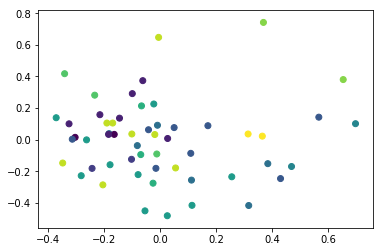

In [554]:
plt.scatter(proj[:vocabulary_size, 0], proj[:vocabulary_size,1],c=assignments)

## Visualizing the embedding space of notes

In [557]:
midiNotes = [midi_to_note_name(reverse_dictionary[i]) for i in range(len(reverse_dictionary))]

In [558]:
proj.shape

(55, 2)

In [559]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, LabelSet
from bokeh.io import output_notebook

In [560]:
output_notebook()

Loading BokehJS ...

In [382]:
p = figure(plot_width=400, plot_height=400,
           title=None, toolbar_location="below")

In [383]:
source = ColumnDataSource(
        data=dict(
            xs=proj[:len(midiNotes),0],
            ys=proj[:len(midiNotes),1],
            midiNotes=midiNotes,
        )
    )

hover = HoverTool(
        tooltips=[
            ("midiNotes", "@midiNotes"),
        ]
    )

labels = LabelSet(x='xs', y='ys', text='midiNotes', level='glyph',
              x_offset=5, y_offset=5, source=source, render_mode='canvas')

p = figure(plot_width=400, plot_height=400, tools=[hover, 'box_zoom', 'reset'])
p.circle('xs', 'ys', source=source)

p.add_layout(labels)

show(p)